In [1]:
import pandas as pd
from pathlib import Path

In [2]:
import os
print(os.listdir("../input"))


['test.csv.zip', 'sample_submission.csv', 'train.csv', 'test.csv', 'sample_submission.csv.zip', 'description.md', 'train.csv.zip', 'train.zip', 'spooky-author-identification']


In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import re
from nltk.tokenize import sent_tokenize, word_tokenize
import gensim 
from gensim.models import Word2Vec


In [4]:
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')
print(train_df.shape, test_df.shape)


(17621, 3) (1958, 2)


In [5]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text) # remove everything that isn't word or space
    text = re.sub(r'\_', '', text)      # remove underscore
    return text


In [6]:
# clean train_df['text']
train_df['text'] = train_df['text'].map(lambda x: clean_text(x))
train_df['text'] = train_df['text'].map(lambda x: x.strip().split())
train_df.head()


,id,text,author
0,id06121,"[so, i, did, not, abandon, the, search, until,...",EAP
1,id01074,"[he, had, promised, to, spend, some, hours, wi...",MWS
2,id12145,"[in, the, end, he, give, him, a, funny, kind, ...",HPL
3,id18286,"[what, other, construction, could, i, possibly...",EAP
4,id11118,"[i, had, heard, the, noise, however, faint, an...",EAP


In [7]:
test_df['text'] = test_df['text'].map(lambda x: clean_text(x))
test_df['text'] = test_df['text'].map(lambda x: x.strip().split())
test_df.head()


,id,text
0,id27251,"[there, seemed, to, be, a, void, and, nothing,..."
1,id09612,"[this, event, caused, many, of, those, who, we..."
2,id11943,"[i, hastily, gave, my, consent, to, this, arra..."
3,id19526,"[it, were, useless, to, record, the, debate, t..."
4,id12931,"[but, how, are, we, to, judge, of, airs, and, ..."


In [8]:
data = []  
# iterate through each row in train_df 
for i in range(len(train_df)):
    data.append(train_df['text'][i])
for j in range(len(test_df)):
    data.append(test_df['text'][j])


In [9]:
print(len(data))


19579


In [10]:
# Create CBOW model 
embedding = gensim.models.Word2Vec(data, size = 50, window = 5, min_count = 1, workers=4)


TypeError: Word2Vec.__init__() got an unexpected keyword argument 'size'

In [11]:
embedding.train(data,total_examples=len(data),epochs=30)


NameError: name 'embedding' is not defined

In [12]:
# convert author labels into one-hot encodings
train_df['author'] = pd.Categorical(train_df['author'])
df_Dummies = pd.get_dummies(train_df['author'], prefix='author')
train_df = pd.concat([train_df, df_Dummies], axis=1)
# Check the conversion
train_df.head()


,id,text,author,author_EAP,author_HPL,author_MWS
0,id06121,"[so, i, did, not, abandon, the, search, until,...",EAP,True,False,False
1,id01074,"[he, had, promised, to, spend, some, hours, wi...",MWS,False,False,True
2,id12145,"[in, the, end, he, give, him, a, funny, kind, ...",HPL,False,True,False
3,id18286,"[what, other, construction, could, i, possibly...",EAP,True,False,False
4,id11118,"[i, had, heard, the, noise, however, faint, an...",EAP,True,False,False


In [13]:
X = train_df['text']
Y = train_df[['author_EAP', 'author_HPL', 'author_MWS']].values


In [14]:
print(X.shape, X[0])
print(Y.shape, Y[0])


(17621,) ['so', 'i', 'did', 'not', 'abandon', 'the', 'search', 'until', 'i', 'had', 'become', 'fully', 'satisfied', 'that', 'the', 'thief', 'is', 'a', 'more', 'astute', 'man', 'than', 'myself']
(17621, 3) [ True False False]


In [15]:
X_test = test_df['text']
print(X_test.shape, X_test[0])


(1958,) ['there', 'seemed', 'to', 'be', 'a', 'void', 'and', 'nothing', 'more', 'and', 'i', 'felt', 'a', 'childish', 'fear', 'which', 'prompted', 'me', 'to', 'draw', 'from', 'my', 'hip', 'pocket', 'the', 'revolver', 'i', 'always', 'carried', 'after', 'dark', 'since', 'the', 'night', 'i', 'was', 'held', 'up', 'in', 'east', 'providence']


In [16]:
def text_to_avg(text):
    """Given a list of words, extract the respective GloVe representations
    and average the values into a single vector encoding the text meaning."""
    # initialize the average word vector
    avg = np.zeros((50,))
    # average the word vector by looping over the words in text
    for w in text:
        avg += embedding[w]
    avg = avg/len(text)
    return avg


In [17]:
X_avg = np.zeros((X.shape[0], 50)) # initialize X_avg
for i in range(X.shape[0]):
    X_avg[i] = text_to_avg(X[i])


NameError: name 'embedding' is not defined

In [18]:
print(X_avg.shape)
print(X_avg[0])


(17621, 50)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


In [19]:
X_test_avg = np.zeros((X_test.shape[0], 50)) # initialize X_test_avg
for i in range(X_test.shape[0]):
    X_test_avg[i] = text_to_avg(X_test[i])


NameError: name 'embedding' is not defined

In [20]:
print(X_test_avg.shape)
print(X_test_avg[0])


(1958, 50)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


In [21]:
from sklearn.model_selection import train_test_split
X_train, X_dev, Y_train, Y_dev = train_test_split(X_avg, Y, test_size=0.2, random_state=123)
print(X_train.shape, Y_train.shape, X_dev.shape, Y_dev.shape)


(14096, 50) (14096, 3) (3525, 50) (3525, 3)


In [22]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(50, activation='relu', input_shape=(50,)))
model.add(layers.Dense(3, activation='softmax'))

model.summary()


2025-08-18 21:52:22.555507: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755553942.570303       8 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755553942.574543       8 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-18 21:52:22.590818: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_d

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,703 (10.56 KB)

 Trainable params: 2,703 (10.56 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# compile the model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])


In [24]:
# train and validate the model for 30 epochs
history = model.fit(X_train, Y_train, epochs=30, batch_size=None, validation_data=(X_dev, Y_dev))


Epoch 1/30
441/441 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4046 - loss: 1.0935 - val_accuracy: 0.3955 - val_loss: 1.0898
Epoch 2/30
441/441 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - accuracy: 0.3993 - loss: 1.0886 - val_accuracy: 0.3955 - val_loss: 1.0899
Epoch 3/30
441/441 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step - accuracy: 0.4156 - loss: 1.0840 - val_accuracy: 0.3955 - val_loss: 1.0898
Epoch 4/30
441/441 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step - accuracy: 0.4039 - loss: 1.0875 - val_accuracy: 0.3955 - val_loss: 1.0898
Epoch 5/30
441/441 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - accuracy: 0.4118 - loss: 1.0849 - val_accuracy: 0.3955 - val_loss: 1.0898
Epoch 6/30
441/441 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step - accuracy: 0.3967 - loss: 1.0894 - val_accuracy: 0.3955 - val_loss: 1.0900
Epoch 7/30
441/441 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step - accuracy: 0.4093 - loss: 1.0859 - val_accuracy: 0.3955 - val_loss: 1.0899
Epoch 8/30
441/441 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step - accuracy: 0.4015 - loss: 1.0878 - va

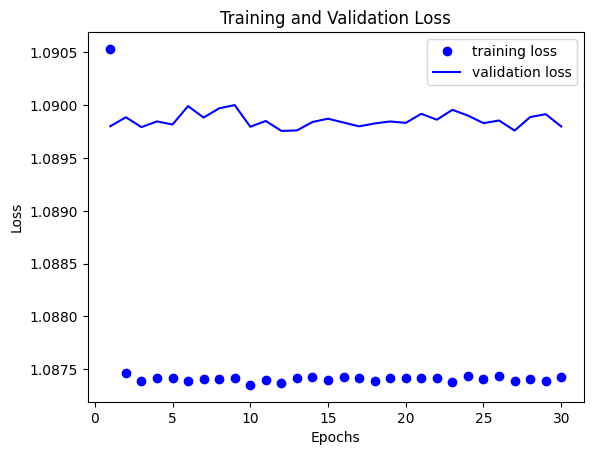

In [25]:
# plot and visualise the training and validation losses
loss = history.history['loss']
dev_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, dev_loss, 'b', label='validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [26]:
model = models.Sequential()
model.add(layers.Dense(50, activation='relu', input_shape=(50,)))
model.add(layers.Dense(3, activation='softmax'))
# compile the model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])


In [27]:
# train the model for 10 epochs
model.fit(X_avg, Y, epochs=10, batch_size=None)


Epoch 1/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 611us/step - accuracy: 0.4033 - loss: 1.0929
Epoch 2/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step - accuracy: 0.4048 - loss: 1.0876
Epoch 3/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step - accuracy: 0.4025 - loss: 1.0877
Epoch 4/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 613us/step - accuracy: 0.4043 - loss: 1.0874
Epoch 5/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 606us/step - accuracy: 0.4039 - loss: 1.0875
Epoch 6/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step - accuracy: 0.3963 - loss: 1.0895
Epoch 7/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 621us/step - accuracy: 0.4012 - loss: 1.0884
Epoch 8/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step - accuracy: 0.4067 - loss: 1.0866
Epoch 9/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 612us/step - accuracy: 0.4017 - loss: 1.0878
Epoch 10/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step - accuracy: 0.4015 - loss: 1.0879


In [28]:
# predict on test set
preds = model.predict(X_test_avg)
print(preds.shape)
print(preds[7])


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step
(1958, 3)
[0.4030755  0.2870784  0.30984598]


In [29]:
# set the predicted labels to be the one with the highest probability
pred_labels = []
for i in range(len(X_test_avg)):
    pred_label = np.argmax(preds[i])
    pred_labels.append(pred_label)


In [30]:
print(pred_labels[7])


0


In [31]:
result = pd.DataFrame(preds, columns=['EAP','HPL','MWS'])
result.insert(0, 'id', test_df['id'])
result.head()


,id,EAP,HPL,MWS
0,id27251,0.403075,0.287078,0.309846
1,id09612,0.403075,0.287078,0.309846
2,id11943,0.403075,0.287078,0.309846
3,id19526,0.403075,0.287078,0.309846
4,id12931,0.403075,0.287078,0.309846


In [32]:
# Generate submission file in csv format
result.to_csv('submission.csv', index=False, float_format='%.20f')
